# Imports

In [13]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn import metrics
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
import forestci as fci
import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed
import warnings
warnings.filterwarnings("ignore")

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="LogPC"):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    # plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    plt.scatter(y_train,y_pred_train,label="training",color="black",marker=".",s=200) # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color='red',marker=".",linewidth=3, s=200)     #,alpha=0.25  "#8da9f5"
    plt.plot(y_train,yy_fit_line,color="darkgrey",linestyle='--',dashes=[5,15]) #,alpha=0.2
    if leg:
        plt.legend(loc='lower right', fontsize=10)
    plt.xlabel(label+" measured",fontsize=18, fontweight='bold')
    plt.ylabel(label+" predicted",fontsize=18, fontweight='bold')
    
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav, dpi=300, bbox_inches='tight', transparent=True)

def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)        

import random


# Reading data

In [10]:
#### all data in a single file
# HDC Changes: lines 6,8,9, and 16(header=0 instead of header=4) to reflect spreadsheet setup
excel_file ="QikProp_modeling_input" 
excel_sheet = "data" 
num_par = 53
par_start_col = 9  # 0-indexed
num_samples = 3926
response_col = 2   # 0-indexed
y_label_col = 1    # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True


inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=list(range(0,(num_par+par_start_col))))

if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

n_samples before removing empty cells: 3926
Removing 0 samples.
Shape X: (3926, 53)
Shape y: (3926,)
Shape labels: (3926,)
First X cell: 0.0
Last X cell:  527.25
First y: -0.26
Last y:  0.03092339962721902
Last label: D-Gluconate


In [3]:
# Remove collinear params (optional)
# Only run this cell once!
threshold = 0.9
print(X.shape)
df_in = pd.DataFrame(X, columns=X_labels)               # making a copy of the df
df_corr = df_in.corr()     # making the correlation matrix
df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
df3 = df_in[un_corr_idx]
X = df3
print(X.shape)
print(df3.shape)
# adjust data labels and format
X_labels = (df3.columns)
X_names = X_labels
resp_label = list(inp.columns)[response_col-1]
X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels
X_all = X

(3926, 53)
(3926, 42)
(3926, 42)


# Data preparation: Training/Test set split, Scaling

y_mean TS: 0.619
y_mean VS: 0.568
Shape X_train: (2725, 42)
Shape X_test:  (1201, 42)


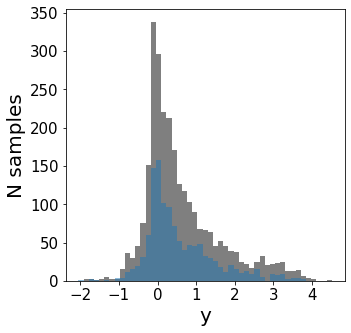

TS: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [4]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# defined training/test split based on clustering of UMAP (see text and Methods for details)

split = "define"
test_ratio = 0.3

    
if split == "define":
   # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    VS = [i for i in range(2725,3926)]
    TS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]

else: 
    raise ValueError("split option not recognized")
     

print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
print("TS: {}".format(TS))
print("VS: {}".format(VS))

## Feature Scaling 

In [5]:
# scale features 
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

## Modelling

Training R2;Test R2;0.71;0.49


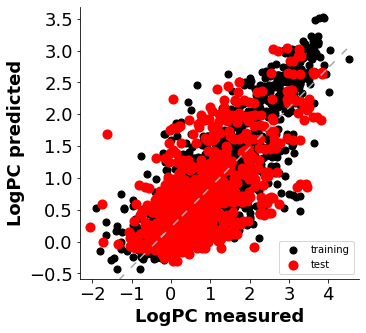

Test MAE:
0.4638872587651775
Feature Importances:
[0.00875084 0.00177982 0.00807191 0.02486006 0.01110113 0.0053484
 0.00946795 0.00201156 0.01383675 0.00907303 0.0094292  0.01352623
 0.02621804 0.01391128 0.0137471  0.02150562 0.02043286 0.02042182
 0.02657854 0.00750482 0.03059522 0.01528456 0.05934844 0.1687358
 0.16035904 0.02343859 0.01454008 0.01740438 0.01405245 0.01736377
 0.01018852 0.01284572 0.         0.0140878  0.00800974 0.11588208
 0.         0.01017007 0.01433173 0.         0.0160295  0.00975557]


In [14]:
# Extreme Gradient Boosted Trees (XGBoost)
data = X_train_sc
label = y_train 
dtrain = xgb.DMatrix(X_train_sc, y_train)
dtest = xgb.DMatrix(X_test_sc, y_test)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',  learning_rate = 0.15, max_depth = 4, n_estimators = 25, subsample = 0.8, min_child_weight = 2, max_delta_step = 2)
xg_reg.fit(X_train_sc,y_train)
y_pred_test = xg_reg.predict(X_test_sc)
y_pred_train = xg_reg.predict(X_train_sc)
print("Training R2;Test R2;{:.2f};{:.2f}".format(xg_reg.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   
print("Test MAE:")
print(metrics.mean_absolute_error(y_test,y_pred_test))
print("Feature Importances:")
print(xg_reg.feature_importances_)


Split method: define
Test ratio: 0.3

Training R2;Test R2;0.79;-0.19


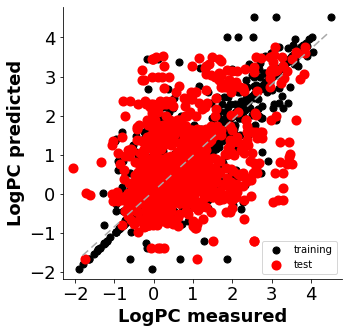

Train MAE:
0.19387299524731627
Test MAE:
0.6954855509661806
Feature Importances:
[1.64850945e-03 4.46720672e-03 4.15190143e-04 3.47335975e-04
 5.80708112e-03 1.56061206e-02 1.12825607e-02 5.61447960e-03
 2.74505500e-02 2.36182332e-02 2.30813719e-02 1.33423589e-02
 1.35434218e-02 1.30609420e-02 8.29357874e-03 6.63759360e-03
 3.88925257e-02 1.83182124e-02 9.40890610e-03 1.86720959e-02
 2.38668944e-02 3.26289814e-02 8.08483069e-02 3.55778688e-02
 2.49573688e-01 1.53738810e-02 8.77468925e-03 5.53418081e-03
 1.66822424e-02 1.99959984e-02 4.99566669e-02 6.69390953e-03
 7.98481532e-03 4.75116942e-03 2.11645707e-03 4.81012971e-04
 2.38987497e-03 1.93801135e-02 1.31645655e-04 1.46551566e-02
 1.66432784e-02 1.26450894e-01]


In [16]:
# Random Forest (RF) Regressor with the option to implement cost complexity pruning (CCP).
n_trees = 1000
max_feats = None
ccp = 0.00 # non-zero number will implement CCP. Reccommened values 0 to 0.05.

# Train RF model
rf  = RandomForestRegressor(n_estimators=n_trees,random_state=4,max_features=max_feats,criterion="mae",max_depth=None, ccp_alpha=ccp)
rf.fit(X_train_sc, y_train)
rf_y_hat = rf.predict(X_test_sc)
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)

# Print model stats and information
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))
print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
# print(np.where(llcv.coef_ != 0)[1])

# Plot rf predicitons vs experimental
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   
print("Train MAE:")
print(metrics.mean_absolute_error(y_train,y_pred_train))
print("Test MAE:")
print(metrics.mean_absolute_error(y_test,y_pred_test))
# Print rf feature importances
print("Feature Importances:")
importances = rf.feature_importances_
print(importances)


Split method: define
Test ratio: 0.3

Training R2;Test R2;0.60;0.44


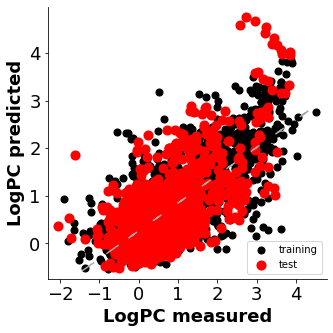

0.4966770165307305


In [17]:
#neural net with MLP regressor
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(random_state=1, 
                  max_iter=100,
                  solver='sgd'
                  ).fit(X_train_sc, y_train)
y_pred_train = nn.predict(X_train_sc)
y_pred_test =  nn.predict(X_test_sc)
print("\nSplit method: {}".format(split))
print("Test ratio: {}\n".format(test_ratio))
print("Training R2;Test R2;{:.2f};{:.2f}".format(
    nn.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test)   
print(metrics.mean_absolute_error(y_test,y_pred_test))